# DBSCAN 성능평가

> iris 데이터 셋

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# 성능평가 지표
from sklearn.metrics import homogeneity_score, completeness_score , v_measure_score, adjusted_rand_score, silhouette_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기 - IRIS

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/iris.xlsx", info=False, categories=['Species'])

## #02. 데이터 전처리

1. 종속변수 제거
2. 데이터 스케일링

In [3]:
y = origin['Species']

df1 = origin.drop(columns=['Species'])
df2 = my_standard_scaler(df1)

## #03. 군집화 모델 

### [1] k개의 최근접 이웃 만들기

In [4]:
k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X=df2)

# 한 점의 최근접 이웃 찾기
distance, indices = neighbors_fit.kneighbors(df2)

# 가까운 순서대로
s_distance = np.sort(distance, axis=0)

target = s_distance[:, k-1]
target

array([0.17890971, 0.18772101, 0.18772101, 0.23710977, 0.23710977,
       0.23710977, 0.23710977, 0.24891184, 0.24891184, 0.24891184,
       0.26013882, 0.2662756 , 0.2662756 , 0.2662756 , 0.2662756 ,
       0.2662756 , 0.2662756 , 0.27119749, 0.27119749, 0.28389113,
       0.28851266, 0.2893036 , 0.2970349 , 0.2970349 , 0.29828781,
       0.31104122, 0.31104122, 0.31104122, 0.31292365, 0.31292365,
       0.31292365, 0.33774794, 0.33774794, 0.33774794, 0.33774794,
       0.33903931, 0.3454853 , 0.34784482, 0.34929282, 0.35304268,
       0.35430096, 0.35781942, 0.35922722, 0.35922722, 0.36350361,
       0.36369587, 0.36369587, 0.36369587, 0.36772361, 0.36772361,
       0.37010854, 0.37444736, 0.38527202, 0.38717219, 0.38717219,
       0.38717219, 0.38906698, 0.38906698, 0.39599996, 0.39599996,
       0.39599996, 0.39599996, 0.4015088 , 0.4015088 , 0.40296883,
       0.40713826, 0.41907182, 0.42253561, 0.42253561, 0.42891719,
       0.42891719, 0.42925026, 0.43013687, 0.43435955, 0.43857

### [2] `eps`값 찾기

In [5]:
k1 = KneeLocator(range(0, len(target)), target, curve='convex', direction='increasing')
eps = k1.elbow_y
point = k1.elbow
print('found elbow: ', eps)
print('found point: ', point)

found elbow:  0.6868185797302817
found point:  133


### [3] 시각화

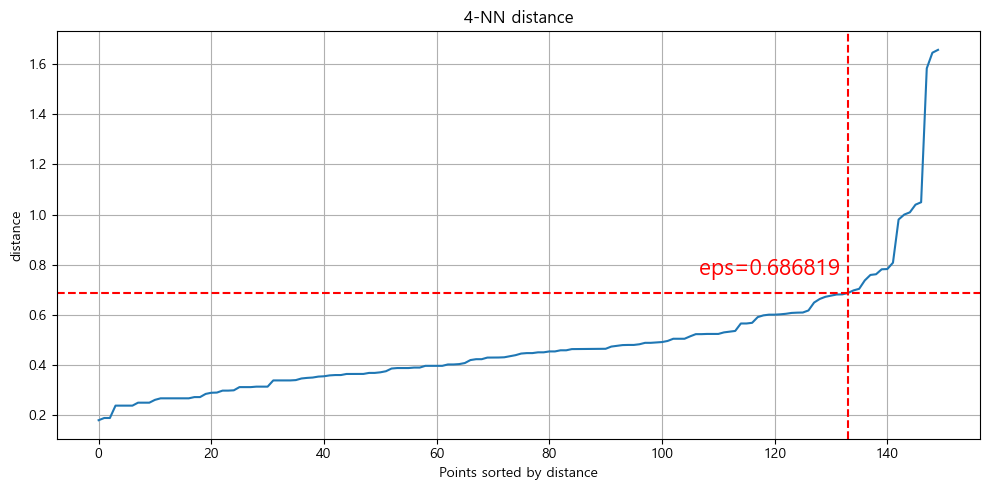

In [7]:
def hvline(ax):
    ax.set_title('%d-NN distance' % k)
    ax.set_ylabel('distance')
    ax.set_xlabel('Points sorted by distance')
        
    ax.axhline(eps, color='red', linestyle='--')
    ax.axvline(point, color='red', linestyle='--')
    ax.text(point, eps+0.05, 'eps=%f ' % eps, fontsize=16, color='r', va='bottom', ha='right')
    
my_lineplot(df=None, xname=range(0, len(target)), yname=target, callback=hvline)
    

### [4] 군집

#### (1) 도출된 `eps`와 `k`값 활용

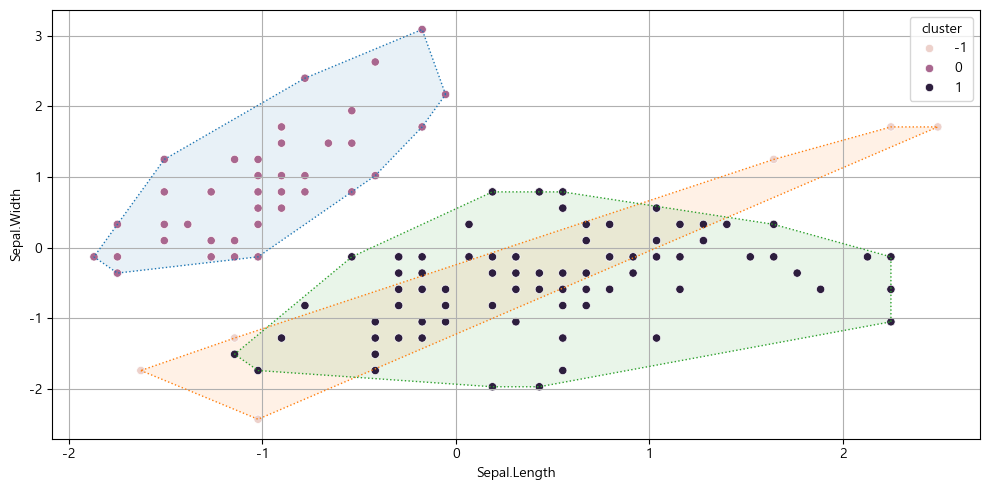

In [8]:
estimator = DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
estimator.fit(df2)

result_df = df2.copy()
result_df['cluster'] = estimator.labels_
my_convex_hull(data=result_df, xname=result_df.columns[0], yname=result_df.columns[1], hue='cluster')

## #04. 군집화의 결과 평가

### [1] 목적변수가 있는 경우

아래 지표는 K-Means에도 적용 가능함

| 평가지표 | 설명 |
|--|--|
| Homogeneity(동질성) | - 각 클러스터의 모든 객체들이 동일한 클래스로부터 온 객체들일 때, 클러스터링 결과는 동질성을 만족시킴<br/>- 0.0에서 1.0까지의 분포를 나타내며 값이 클수록 좋음 |
| Completeness(완전성) | - 각 클래스의 모든 객체들이 동일한 클러스터의 멤버가 될 때, 클러스터링 결과는 완전성을 만족시킴<br/>- 척도 값이 클수록 좋은 알고리즘으로 평가 |
| V-measure(조화평균) | - Homogeneity와 Completeness의 조화 평균<br/>- 동질성 및 완전성 기준이 얼마나 성공적으로 충족었는지 명시적으로 측정<br/>- 0.0과 1.0 사이의 양수값을 가지며 클수록 좋음.<br/>- 표본 수가 1000개 이상이고 군집 수가 10개 미만인 경우 |
| ARI(Adjusted Rand Index) | - 타켓값으로 클러스터링 결과를 평가<br/>- 1과 0사이의 값을 제공 (1=최적, 0=무작위)<br/>- 표본의 크기가 작거나 군집 수가 많은 경우 사용 |

In [9]:
print("homogeneity_score:", homogeneity_score(labels_true=y, labels_pred=estimator.labels_))
print("completeness_score:", completeness_score(labels_true=y, labels_pred=estimator.labels_))
print("v_measure_score:", v_measure_score(labels_true=y, labels_pred=estimator.labels_))
print("adjusted_rand_score:", adjusted_rand_score(labels_true=y, labels_pred=estimator.labels_))

homogeneity_score: 0.5691110445456874
completeness_score: 0.7979840220655582
v_measure_score: 0.66438908517785
adjusted_rand_score: 0.5464223216603212


### [2] 목적 변수가 없는 경우

| 평가지표 | 설명 |
|--|--|
| **Silhouette** | - 앞의 다른 지표와 다르게 레이블이 없는 군집용 지표<br/>- 1과 0사이의 값을 제공 (1=최적, 0=무작위)<br/>- 각 군집간의 거리가 얼마나 효율적으로 분리되어 있는가를 나타냄<br/>&nbsp;&nbsp;* 1에 가까운 값: 근처의 다른 군집과 거리가 멀다는 의미<br/>&nbsp;&nbsp;* 0에 가까운 값: 근처의 다른 군집과 거리가 가깝다는 의미<br/>- 음수값이 나타나는 경우: 잘못된 분류 |

In [12]:
print('silhouette_score:', silhouette_score(X=df2, labels = estimator.labels_))

silhouette_score: 0.5108970376856588


### [3] 실루엣 계수 시각화

In [13]:
def visualize_silhouette(estimator, X_features): 
    if hasattr(estimator, "n_clusters"):
        n_clusters = estimator.n_clusters
    else:
        labels = list(set(estimator.labels_))
        labels = [x for x in labels if x != -1]
        n_clusters = len(labels)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)

    y_lower = 10
    plt.suptitle('Number of Cluster : '+ str(n_clusters)+', ' \
                        'Silhouette Score :' + str(round(sil_avg,3)) )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid()

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_==i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                            facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")


      # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]], X_features[X_features.columns[1]], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    if hasattr(estimator, "cluster_centers_"):
        centers = estimator.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="r",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

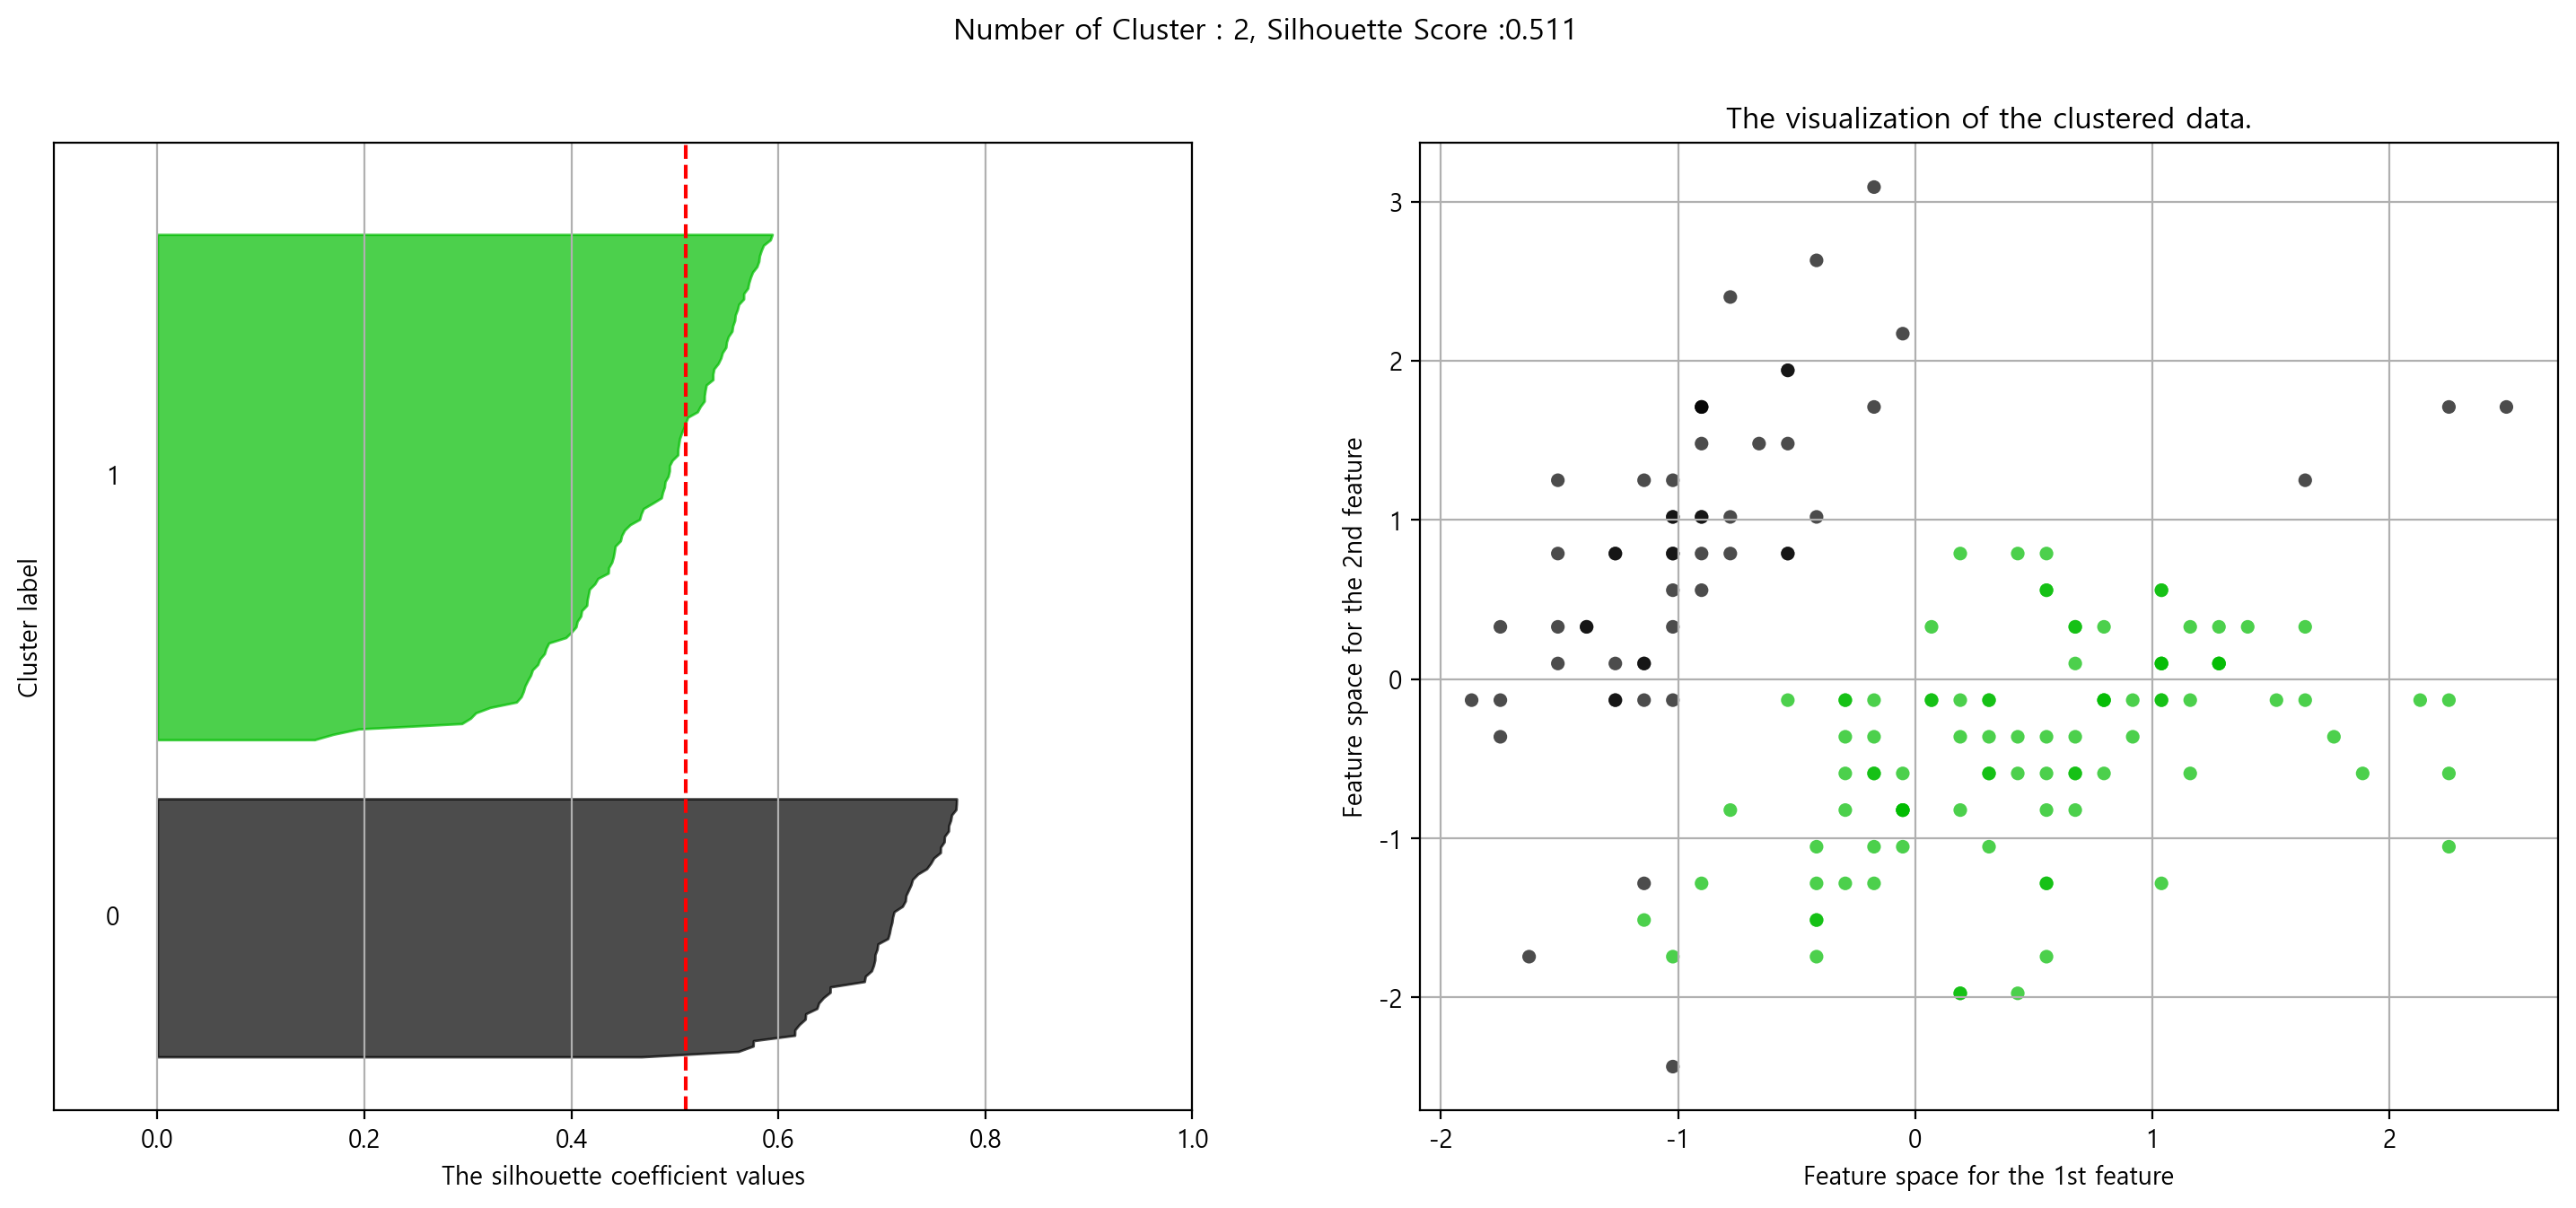

In [14]:
visualize_silhouette(estimator=estimator, X_features=df2)